In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support
import tensorflow as tf 
import tensorflow_addons as tfa
from models import Xception, ResNet50
sns.set_style("darkgrid")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [22]:

df = pd.read_csv('metadata - standardized.csv')
df = pd.DataFrame(df[['names','types']])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   12449 non-null  object
 1   types   12449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 194.6+ KB


In [24]:
df.isnull().sum()

names    0
types    0
dtype: int64

In [25]:
df = df[df['types'] != -1]

0    7549
1    4767
Name: types, dtype: int64


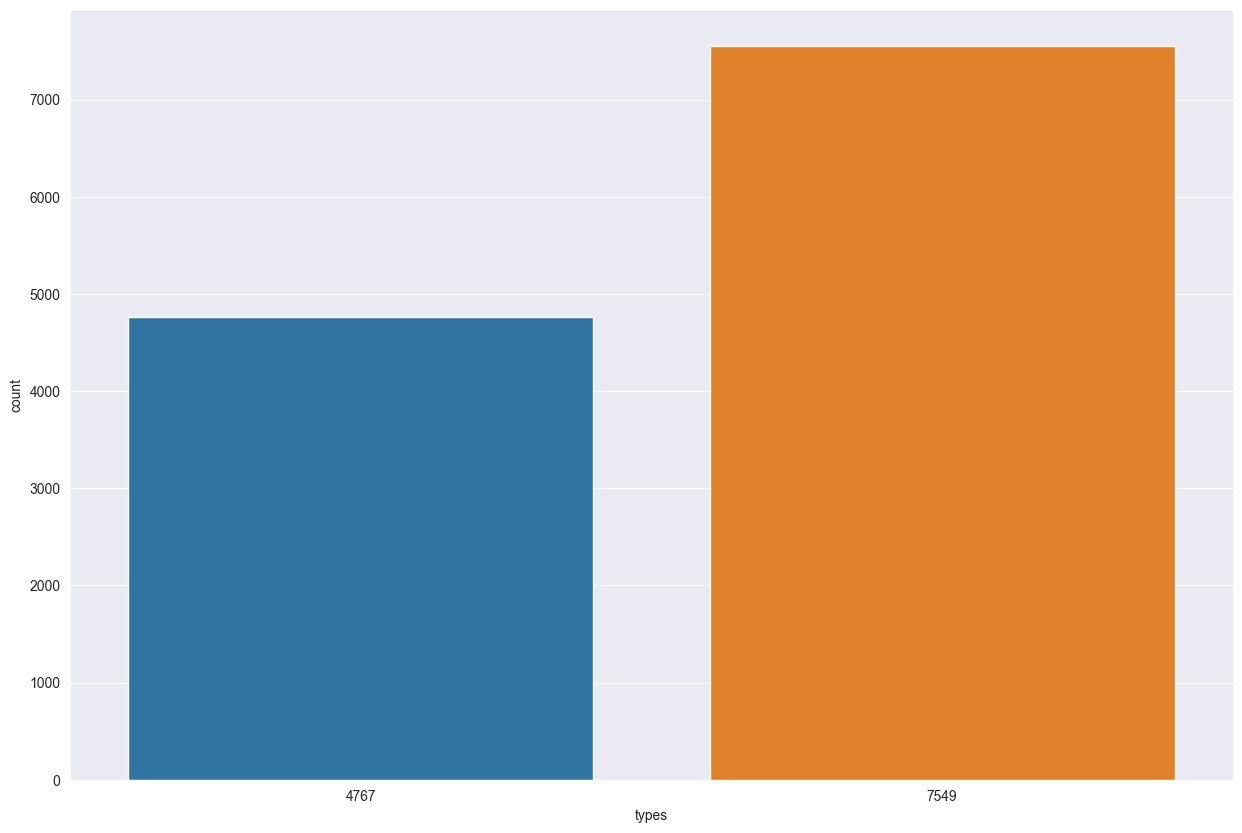

In [26]:
print(df['types'].value_counts())
fig = plt.figure(figsize=(15,10))
sns.countplot(df['types'].value_counts(), x=df['types'])
plt.show()

In [27]:
image_directory = r'full-fundus\full-fundus'
image_size = 256
seed = 12
batch_size = 16

def get_path(name):
    return image_directory + '\\' + name + '.png'

df['path'] = df['names'].apply(get_path)
df.drop('names', axis=1, inplace=True)

In [28]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=seed)
train_data, test_data = train_test_split(train_data, test_size=0.1, random_state=seed)

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8866 entries, 3787 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   8866 non-null   int64 
 1   path    8866 non-null   object
dtypes: int64(1), object(1)
memory usage: 207.8+ KB


In [30]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2464 entries, 446 to 10671
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   2464 non-null   int64 
 1   path    2464 non-null   object
dtypes: int64(1), object(1)
memory usage: 57.8+ KB


In [31]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 7308 to 5484
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   986 non-null    int64 
 1   path    986 non-null    object
dtypes: int64(1), object(1)
memory usage: 23.1+ KB


In [32]:
class ImageGenerator(tf.keras.utils.Sequence):
    """
    Custom Image data generator class from Image paths and labels
    """
    def __init__(self, data: pd.DataFrame, batch_size: int=batch_size, image_size: tuple=image_size, balance: bool=False, augment: bool=False):
        if balance:
            self.data = self.__balance__(data)
        else:
            self.data = data
        self.labels = self.data['types'].values
        self.image_path = self.data['path'].values
        self.batch_size = batch_size
        self.image_size = (image_size, image_size)
        self.augment = augment
        self.augment_pipe = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
            tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
        ])
    
    def __augment__(self, image):
        if np.random.rand() < 0:
            image = self.augment_pipe(image)
        return image

    def __balance__(self, data):
        data_pos, data_neg = data[data['types'] == 1], data[data['types'] == 0]
        data_neg = data_neg.sample(len(data_pos), replace=False, random_state=seed)
        data = pd.concat([data_pos, data_neg])
        data = data.sample(frac=1)
        return data
    
    def __len__(self):
        return np.math.ceil(len(self.image_path) / self.batch_size)

    def __get_image__(self, image_path):
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=self.image_size)
        image = tf.keras.preprocessing.image.img_to_array(image)
        return image
    
    def __getitem__(self, index):

        batch_images = self.image_path[index * self.batch_size : (index + 1) * self.batch_size]
        batch_images = np.array([self.__augment__(self.__get_image__(path)) for path in batch_images]) / 255.0
        batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
        return batch_images, batch_labels

In [33]:
train_dataset = ImageGenerator(train_data, balance=True, augment=True)
val_dataset = ImageGenerator(val_data, balance=False, augment=False)
test_dataset = ImageGenerator(test_data, balance=False, augment=False)

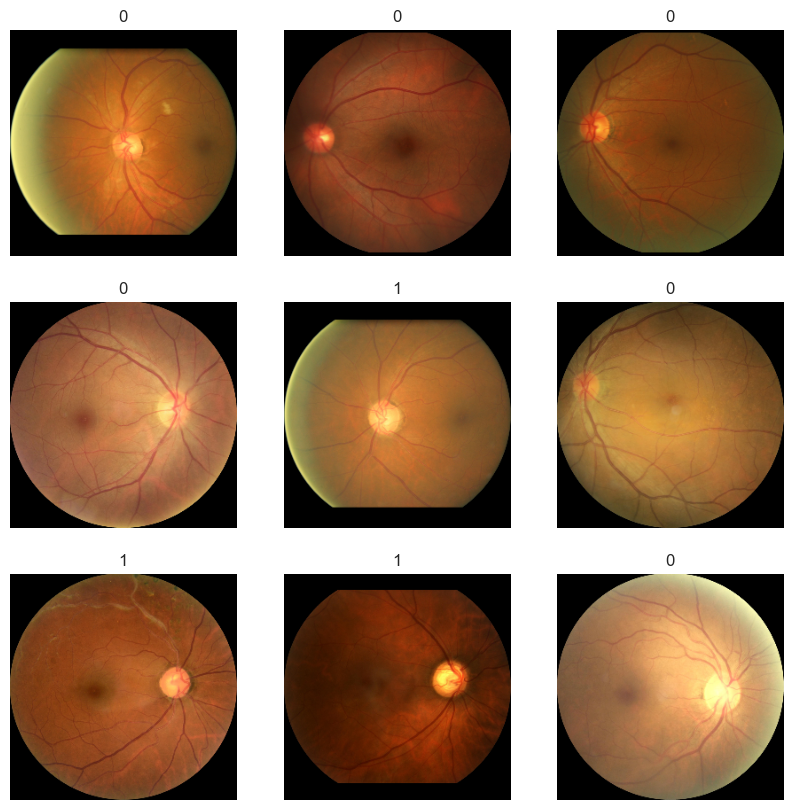

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
im,l = train_dataset.__getitem__(np.random.randint(0, len(train_dataset)))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(im[i])
  plt.title(l[i])
  plt.axis("off")

## ResNet50 Model

### Initializing

#### Hyperparameters

In [35]:
learning_rate = 0.001
weight_decay = 0.0006
beta = 0.5
num_epochs = 10
checkpoint_filepath_res = r'resnet_weights.h5'

#### Trainer

In [37]:
def run_training(model, load_checkpoint=True):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, 
        weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
           'accuracy',
        ],
    )

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath_res,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )

    if load_checkpoint:
        model.load_weights(checkpoint_filepath_res)

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        callbacks=[checkpoint_callback,
                   early_stopping_callback,
                   ],
    )
    return history

#### Evaluator

In [38]:
def run_evalutation(model, dataset):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, 
        weight_decay=weight_decay, 
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
           'accuracy',
        ],
    )
    model.load_weights(checkpoint_filepath_res)
    _, accuracy = model.evaluate(dataset)
    predictions = model.predict(dataset)
    predictions = tf.where(predictions < 0.5, 0, 1)
    report  = classification_report(dataset.labels, predictions)
    return accuracy, report


### Building the Model

In [39]:
tf.keras.backend.clear_session()
res_classifier = ResNet50(input_shape=(image_size, image_size, 3), num_classes=1).build_model()

### Training

In [40]:
history = run_training(res_classifier, load_checkpoint=False)

Epoch 1/10
431/431 [==============================] - 145s 317ms/step - loss: 0.5562 - accuracy: 0.7368 - val_loss: 0.6916 - val_accuracy: 0.6201
Epoch 2/10
431/431 [==============================] - 119s 275ms/step - loss: 0.4774 - accuracy: 0.7748 - val_loss: 0.6890 - val_accuracy: 0.6218
Epoch 3/10
431/431 [==============================] - 122s 284ms/step - loss: 0.4767 - accuracy: 0.7741 - val_loss: 0.6255 - val_accuracy: 0.7399
Epoch 4/10
431/431 [==============================] - 124s 287ms/step - loss: 0.4953 - accuracy: 0.7619 - val_loss: 0.6380 - val_accuracy: 0.6907
Epoch 5/10
431/431 [==============================] - 124s 287ms/step - loss: 0.4544 - accuracy: 0.7856 - val_loss: 0.6503 - val_accuracy: 0.6688
Epoch 6/10
431/431 [==============================] - 125s 290ms/step - loss: 0.4452 - accuracy: 0.7992 - val_loss: 0.6197 - val_accuracy: 0.6209
Epoch 7/10
431/431 [==============================] - 125s 289ms/step - loss: 0.4427 - accuracy: 0.7966 - val_loss: 0.6164 -

### Evaluation

62/62 [==============================] - 8s 134ms/step
Accuracy on test dataset:  0.6683570146560669
Classification report:
               precision    recall  f1-score   support

           0       0.65      1.00      0.79       597
           1       1.00      0.16      0.27       389

    accuracy                           0.67       986
   macro avg       0.82      0.58      0.53       986
weighted avg       0.79      0.67      0.58       986

Confusion matrix:



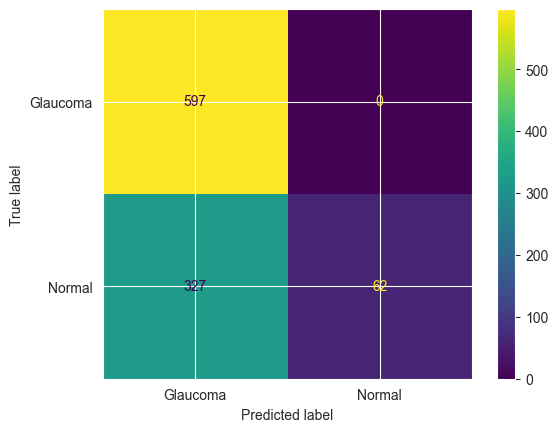

In [41]:
accuracy, report = run_evalutation(res_classifier, test_dataset)
pred_label = res_classifier.predict(test_dataset) > 0.5
precision,recall,f1_score,_ =  precision_recall_fscore_support(test_dataset.labels, pred_label, average='macro')
cm = confusion_matrix(test_dataset.labels, pred_label)
print("Accuracy on test dataset: ", accuracy)
print("Classification report:\n", report)
print("Confusion matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Glaucoma', 'Normal'])
disp.plot()

### Generating the Heatmap

1/1 [==============================] - 2s 2s/step
Predicted label: [[0.]] 
Actual label: 1


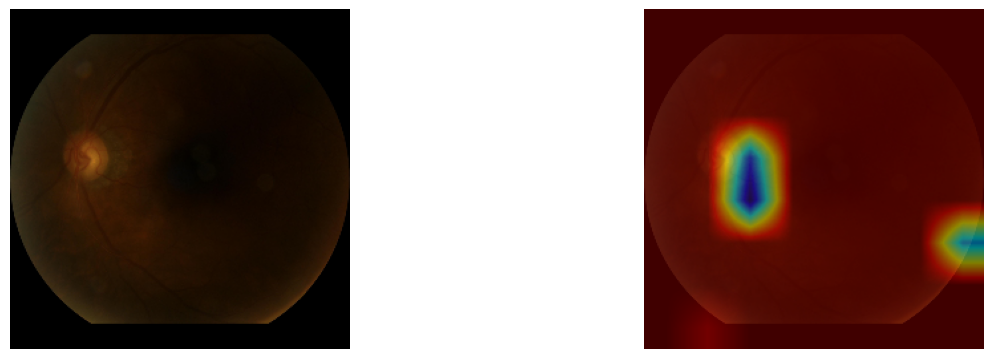

1/1 [==============================] - 0s 34ms/step
Predicted label: [[0.]] 
Actual label: 1


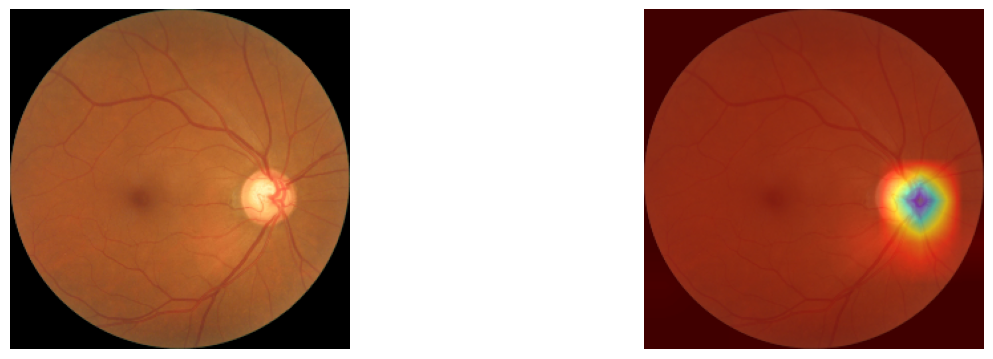

1/1 [==============================] - 0s 29ms/step
Predicted label: [[0.]] 
Actual label: 0


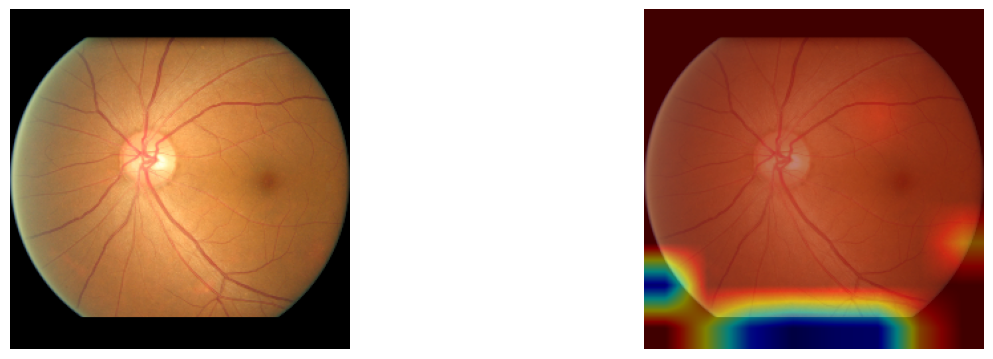

In [43]:
from cam import GRADgen
res_classifier.load_weights(checkpoint_filepath_res)
for i in range(3):
    random_batch = np.random.randint(0, 10)
    random_index = np.random.randint(0, 16)
    output, image, preds = GRADgen(res_classifier, 'conv5_block3_out', test_dataset.__getitem__(random_batch)[0][random_index])
    print(f"Predicted label: {preds} \nActual label: {test_dataset.__getitem__(random_batch)[1][random_index]}")
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(3, 2, 2*i+2)
    plt.imshow(output)
    plt.axis('off')
    plt.show()
